# Simulating a Roomba Vacuum Cleaner in Python

### We build python classes for a tile on a floor, the floor itself and the vacuum cleaner. There are certain attributes of a tile such as the amount of dust and hardness of that dust. The Vaccum cleaner has attributes like its energy, amount of dust it can hold, it's position etc.

### The simulation works on certain rules defined in the code, such as mathematical formulas for removal of dust and algorithms for the vacuum cleaner to follow if it is low on energy or full of dust and needs to unload

In [ ]:
""" This section imports all the required libraries """

import numpy as np
import scipy.stats as sts
import random
import time
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.patches as mpatches
from IPython.display import HTML, display, clear_output

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='api_key', api_key='api_key')

# Plotting Priors

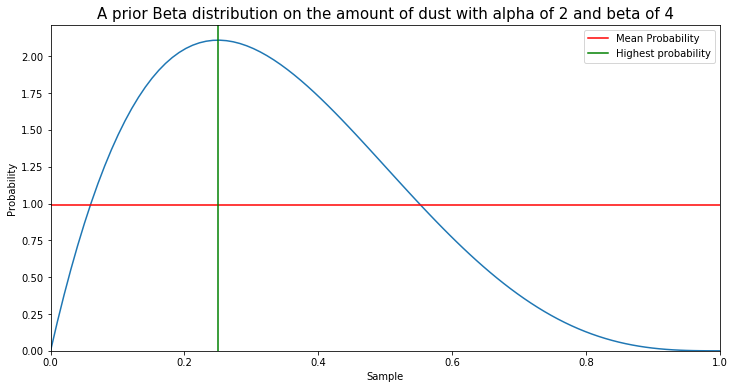

In [2]:
""" This section plots the prior distribution that we'll use to sample the initial dust on a cell """

def dust_prior(x):
    probs = sts.beta(2,4).pdf(x)
    return probs

x = np.linspace(0,1,100)
probs = dust_prior(x)

plt.figure(figsize=(12,6))
plt.title('A prior Beta distribution on the amount of dust with alpha of 2 and beta of 4',fontsize=15)
plt.plot(x,probs)
plt.axhline(np.mean(probs),color='red',label='Mean Probability')
plt.axvline(0.25,color='green',label='Highest probability')
plt.ylabel('Probability')
plt.xlabel('Sample')
plt.ylim(bottom = 0)
plt.xlim(0,1)
plt.legend()
plt.show()

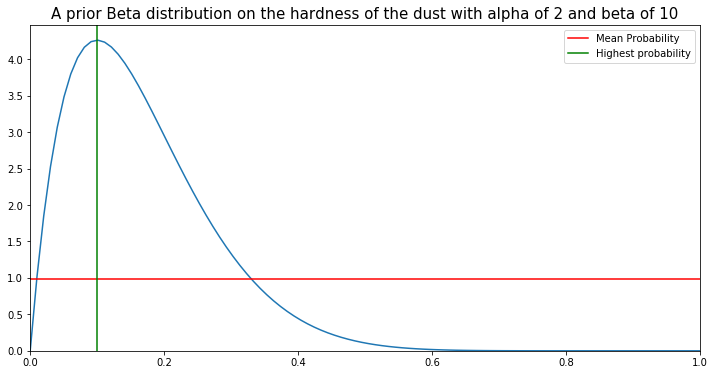

In [3]:
"""  This section plots the prior distribution that we'll use to sample the hardness of dust. """

def hardness_prior(x):
    probs = sts.beta(2,10).pdf(x)
    return probs

x = np.linspace(0,1,100)
probs = hardness_prior(x) # normalized probabilities

plt.figure(figsize=(12,6))
plt.title('A prior Beta distribution on the hardness of the dust with alpha of 2 and beta of 10',fontsize=15)
plt.plot(x,probs)
plt.axhline(np.mean(probs),color='red',label='Mean Probability')
plt.axvline(0.1,color='green',label='Highest probability')
plt.ylim(bottom = 0)
plt.xlim(0,1)
plt.legend()
plt.show()

In [4]:
""" This simulation updates the values of dust for a single cell, similar to our implementation in the 
actual simulation but this allows us to observe and understand the average variation in dust """

def initial_dust_simulation():
    dust = sts.beta(2,4).rvs()
    hardness = sts.beta(2,10).rvs()
    performance = 1
    
    dust_values1 = [dust]
    dust_values2 = [dust]
    
    dust_1 = dust
    
    for i in range(10):
        dust_1 = dust_1*hardness*performance # Our formula
        dust_values1.append(dust_1) # Collecting updated value of dust
        
    s = np.linspace(0,10,101)
    
    # Continuous formuula of dust (deduced in the assignment)
    dust_values2 = dust*np.exp(-s*(1-hardness)*performance) 
    
    # We collect both for comparative purposes
    
    return dust_values1, dust_values2

In [5]:
""" Running 1000 Monte Carlo simulations of the dust simulation above"""

formula_changes = [] 
calculus_changes = []

for _ in range(1000):
    dust1, dust2 = initial_dust_simulation()
    formula_changes.append(dust1)
    calculus_changes.append(dust2)

formula_changes = np.array(formula_changes)
calculus_changes = np.array(calculus_changes)

In [6]:
""" Extracting the means and confidence intervals for the values of dust """

formula_change_means = [np.mean(formula_changes[:,i]) for i in range(11)]
formula_upper =  [np.percentile(formula_changes[:,i],97.5) for i in range(11)]
formula_lower =  [np.percentile(formula_changes[:,i],2.5) for i in range(11)]

calculus_change_means = [np.mean(calculus_changes[:,i]) for i in range(101)]

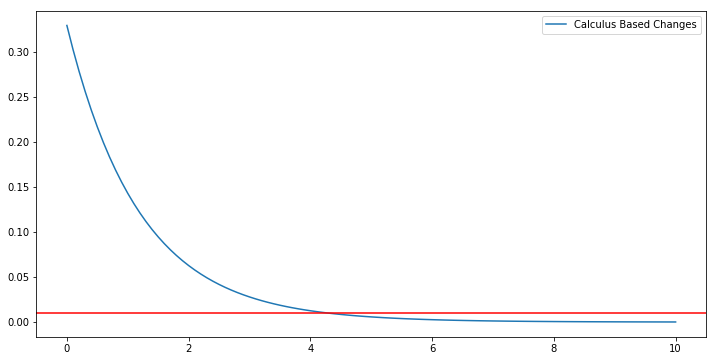

In [7]:
""" Plotting the theoretical continuous variation of dust on a single cell """
x_c = np.array(range(101))/10

plt.figure(figsize=(12,6))
plt.plot(x_c,calculus_change_means,label= 'Calculus Based Changes')
plt.axhline(0.01,color='red')
plt.legend()
plt.show()

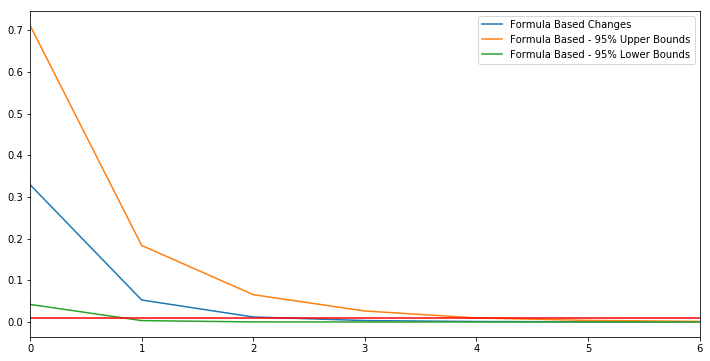

In [8]:
""" Results of the Monte Carlo simulation on the discrete changes in dust on a single cell """

plt.figure(figsize=(12,6))
plt.plot(range(11),formula_change_means ,label= 'Formula Based Changes')
plt.plot(range(11),formula_upper ,label= 'Formula Based - 95% Upper Bounds')
plt.plot(range(11),formula_lower ,label= 'Formula Based - 95% Lower Bounds')
plt.axhline(0.01,color='red')
plt.legend()
plt.xlim(0,6)
plt.show()

# Python Objects and Simulation infrastructure

In [9]:
""" This code block helps us make an animation of the vacuum cleaner on the floor """

# This code block was adopted from C. Scheffler's CoCalc profile (Scheffler, n.d.)

def make_animation(draw_function, frames, interval, filename=None,
                   verbose=False, figure_params=None):
    """ Write an animated GIF to file using matplotlib and ImageMagick.

    Inputs:

        draw_function (callable) The function to call, once per frame, to render to the current 
        matplotlib figure. This function's call signature must be

            draw_function(current_frame_number, total_frame_count)

        The first frame is 0 and the last frame is total_frame_count-1.

        frames (int) The number of frames to generate.

        interval (float) The number of milliseconds to wait between frames in the animation. 
          Set this to 40 for a fairly standard frame rate of 25fps (1 second / 40 (milliseconds
          per frame) = 25 frames per second).

        filename (str) The path to the file to write to. If none is provided, the animation will be 
          written to a random filename, prefixed with"animate_" in the current directory. Default: None.

        verbose (bool) Whether to print the current frame number to the console as the animation is 
          being created. This will clear other console output. Default: False.

        figure_params (dict) The keyword arguments to pass to matplotlib when creating a new figure for 
          this animation. Use it to set the figure size and other figure properties. Default: None.

    Returns: A display object that will inject HTML for displaying the
      animated GIF into the notebook.
    """
    

    if filename is None: # Creating a filename for the animation
        filename = 'animate_%06i.gif' % random.randint(0, 999999)
        
    # Create an initial figure
    
    if figure_params is None:
        figure_params = {}
        
    figure = plt.figure(**figure_params)
    
    # Wrap draw_function if we need to print to console
    
    if verbose:
        old_draw_function = draw_function
        def draw_function(current_frame_number, total_frame_count):
            old_draw_function(current_frame_number, total_frame_count)
            print('Processed frame', current_frame_number + 1, '/', total_frame_count)
            clear_output(wait=True)
            if current_frame_number + 1 == total_frame_count:
                print('Writing animation to file...')
                clear_output(wait=True)
                
    # Generate animation of the given draw function that updates it for every frame
    
    anim = animation.FuncAnimation(
        figure, draw_function, frames=frames, interval=interval,
        init_func=lambda: None, fargs=(frames,))
    
    anim.save(filename, writer='imagemagick')
    
    # Close the animation figure so the last frame does not get displayed
    # in the notebook.
    
    plt.close()
    
    # Return display object for the animated GIF
    return display(HTML('<img src="' + filename + '">'))

In [10]:
class tile():
    
    def __init__(self):
        
        """  This section initializes all the attributes of a cell on the floor
        
        dust:     Samples the amount of dust from a beta distribution with alpha 1 and beta 4
        
        hardness: Samples the hardness of dust from a beta distribution with alpha 2 and beta 4
        
        object:   If the tile has an object on it, the value of object is changed to 2, otherwise 0.
                  We initialize it to 2 because it helps with visualizing it as a dark object.
            
        visits:   Number of visits by the vacuum cleaner on the same tile.   """
        
        self.dust = sts.beta(2,4).rvs()       # Sampling the initial amount of dust
        self.hardness = sts.beta(2,10).rvs()  # Sampling the initial amount of hardness
        self.object = 0                       # Object == 2 if an obstacle is placed here, otherwise 0 
        self.visits = 0                       # Number of visits given to this cell
    
    def clean(self,performance):
        
        """ This section cleans the tile when the cleaner is on the cell.
        
        The cleaning effect depends on:
        
            1. The life performance of the cleaner. 
            2. The hardness of the dust
            3. The amount of the dust itself.
        
        We reduce the dust and count the visit. If the dust is less than 1%, it counts as cleaned.  """
        
        effect = (performance)*(1-self.hardness)*self.dust   # Formula devised in the assignment
        self.dust = self.dust - effect                       # Subtracting the collected dust
        self.visits += 1                                     # Counting the visit
        
        if self.dust < 0.01:                                 # If dust falls below 1%, its clean
            self.dust = 0
        
        return effect   # Return the dust collected 
        # This is then used by the cleaner to track the amount of dust collected
        
    def just_visit(self):
        
        """  This section is used if the cleaner is marked intelligent. It doensn't clean the cell if
        it is already clean and hence, moves over it to the next cell to save energy.   """
        
        self.visits += 1

In [11]:
class vacuum_cleaner():
    
    def __init__(self,battery_usage):
        
        """ This section initializes all the attributes of the cleaner
        
        energy:      This is the amount of charge left on the vacuum cleaner.
        
        performance: As the vacuum cleaner is used more, it's efficiency should decrease.
                     Performance decreases 1% times the efficiency for every cell that the cleaner cleans.   
        
        battery usage:  This is a measure of the battery efficiency in the vacuum cleaner.
                     For every 1 visit, the battery drops by efficiency %
            
        total energy used:   Counts the total amount of energy used. 
                             This will be useful for analysis of the most efficient strategy.  """
        
        if type(battery_usage) != float or battery_usage < 0 or battery_usage > 1:
            raise Exception('The battery usage should be a float between 0 and 1 (both inclusive)')
        
        self.energy = 1                    # Initialized to 1
        self.performance = 1               # Initialized to 1
        self.battery_usage = battery_usage # Amount of drop in battery per step
        self.total_energy_used = 0        # Collecting all the battery used
        self.dust_held = 0                 # The total dust held by the vacuum cleaner
        self.dust_collected = []           # Total dust collected - overall
        
    def cleaned(self, amount):
        
        """ This section cleans the tile and makes the required changes to the cleaner.
        
            1. For every 1 cell, the energy goes down.
            2. The performance also does down after every use.
        
        If it recognizes that future_performance will be too low, it declares the cleaner 
        as fully inefficient which means that it won't be able to clean any new cells. """
        
        self.energy -= self.battery_usage                 # Update the battery
        self.total_energy_used += self.battery_usage # Record the total amount of energy used
        
        if self.performance <= 0: # If 0, it remains at 0
            self.performance = 0
            
        else: # Otherwise, it is reduced as per the formula discussed earlier
            self.performance = self.performance - self.battery_usage*0.01
            
        self.dust_held += amount            # Updating the total amount of dust held in the vacuum cleaner
        self.dust_collected.append(amount)  # Collecting the total amount of dust collected - overall            
    
    def just_move(self):
        
        """ This section is only used for intelligent cleaners.
        
            1. It counts the step
            2. It uses only 10% of the normal energy required
            3. It also adds the energy used to the total energy used.
            4. It doesn't affect the cleaner's life performance.  """
        
        self.energy -= 0.1*self.battery_usage             # Update battery as per the formula
        self.total_energy_used += 0.1*self.battery_usage  # Update total energy used as per the formula
        

In [ ]:
class floor():
    
    def __init__(self,length,breadth,battery_usage):
        
        """ This section initializes all the attributes of the floor itself
        
        length, breadth:        Defines the shape of the room  
        floor:                  Numpy array with tile objects at every location
        cleaner position:       The position of the vacuum cleaner object 
        cleaner:                Initializes the vacuum cleaner object 
        all_clean:              This is a boolean value that helps us detect 
                                the cleanliness status of the floor.
        
        average dust:           Tracks the amount of average dust on the floor for each step
        average visits:         Tracks the average number of visits for all cells
        cleaning times:         Tracks the average time taken to clean a call and reprioritize """
        
        # Dimensions of the floor grid
        self.length = length      
        self.breadth = breadth
        
        # Initializing the tile objects on every cell
        self.floor = np.array([[tile() for i in range(breadth)] for j in range(length)])
        self.cleaner = vacuum_cleaner(battery_usage)
        self.all_clean = False
        
        self.average_dust = []
        self.average_visits = []
        self.cleaning_times = []
    
        
    def initialize(self):
        """ This section initializes the following things:
        
            1.  9 distinct cells are used to initialize a table
            2.  5% of the total floor area is used for chairs of cell area each
            3.  A random position for the cleaner that is not an obstacle.        """
        
        # Initiializing the table in the middle
        table_index = [self.length//2, self.breadth//2]
        
        # Changing the object attribute so that the cleaner can identify it as an obstacle
        for dx in [-1,0,1]:
            for dy in [-1,0,1]:
                self.floor[table_index[0]+dx,table_index[1]+dy].object = 2
                
        # Selecting 5% of the cells and changing them to chair obstacles
        for _ in range(int(self.length*self.breadth*0.05)):
            chair_index = (random.choice(range(1,self.length-1)),random.choice(range(1,self.breadth-1)))
            
            if self.floor[chair_index].object != 2:
                self.floor[chair_index].object = 2
        
        # Collect initial data - function used later
        self.collect_data()
        
        # Initializing the cleaner
        x = random.choice(range(self.length))
        y = random.choice(range(self.breadth))
        
        self.cleaner_position = (x,y)
        
        # Making sure that the cleaner isn't placed on an obstacle
        while self.floor[self.cleaner_position].object != 0:
            x = random.choice(range(self.length))
            y = random.choice(range(self.breadth))
            self.cleaner_position = (x,y)
        
        # Finalizing the cleaner's position as a numpy array 
        # This helps us do addition with the direction easily
        
        self.cleaner_position = np.array([self.cleaner_position[0],self.cleaner_position[1]])
                
    def observe(self):
        """ This section helps us plot the floor:
        
            1.  It collects the amount of dust on each cell.
            2.  If the cell has an object, it is initialized to 2. (Very Dark)
            3.  If the call has the cleaner, it is initialized to 1.5. (Orange)  """
        
        plot_floor = np.zeros((self.length,self.breadth)) # Array for plotting
        
        for i in range(self.length): 
            for j in range(self.breadth):
                if self.floor[i,j].object == 0:     # If empty, collect dust value
                    plot_floor[i,j] = self.floor[i,j].dust  
                else:                               # If not empty, equal to 2
                    plot_floor[i,j] = self.floor[i,j].object
        
        # The values for the variation in colors
        values = np.array([0,0.25,0.5,1.5,2])
        
        # Cleaner's position as 1.5 (orange)
        plot_floor[self.cleaner_position[0],self.cleaner_position[1]] = 1.5
        
        # Plotting the figure with important metrics in the title
        #plt.figure(figsize=(self.length,self.breadth))
        plt.title('Cleaner Energy: {}'.format(round(self.cleaner.energy*100,2)) + \
                  ', Average Dust: {}'.format(round(self.average_dust[-1],2)) + \
                  ', Dust Collected: {}'.format(round(self.cleaner.dust_held,2))
                 )
        # Showing the floor with the Yellow/Brown Colormap
        im = plt.imshow(plot_floor, cmap = 'YlOrBr' )
        
        # Mapping the colors to the values for the legend
        colors = [ im.cmap(im.norm(value)) for value in values]
        labels = ['Clean','Moderately Unclean','Very Unclean','Vacuum Cleaner','Obstacle']
        
        patches = [ mpatches.Patch(color=colors[i], label= labels[i]) \
                   
                   for i in range(len(values))]
        # Showing the legend with the color patches and labels
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
        #plt.show()
        
    def energy_and_dust_check(self,intelligent):
        
        """ This section checks whether the vacuum cleaner is low on energy.  
            An intelligent vacuum cleaner requires only 10% energy for a move. """

        max_steps_required_to_return = sum(self.cleaner_position)
        
        if intelligent: # Intelligent model only requires 10% for empty steps
            multiplier = 0.1 
            
        else:           # Non-Intelligent model doesn't differentiate between cleaning and just moving
            multiplier = 1
        
        """ Evaluating whether the vacuum cleaner's energy is low enough to go back """
        
        energy_low = True if self.cleaner.energy <= multiplier* \
                self.cleaner.battery_usage*max_steps_required_to_return else False
        
        """ This section checks whether the vacuum cleaner is almost full of dust.  """
        
        dust_full = True if self.cleaner.dust_held >= 24  else False
        
        """ If low on energy or high on dust, the vacuum cleaner goes back """ 
        
        if energy_low or dust_full: 
            self.cleaner_position = np.array([0,0])
            self.cleaner.dust_held = 0  
            self.cleaner.energy = 1
    
    def add_dust(self):
        
        """ Adds dust to a random cell """
        dust_added = False
        
        while not dust_added: # Selects a cell that is not an object and adds 1% dust
            
            index = (random.choice(range(self.length)),random.choice(range(self.breadth)))
            if self.floor[index].object == 0:
                self.floor[index].dust = min([1, self.floor[index].dust + 0.01])
                dust_added = True
    
    def collect_data(self):
            
        """  This section collects the following data for visualization purposes. 
                1. The average amount of dust on the floor. 
                2. The average amount of visits given to each cell   """
        
        dust = []
        visits = []
        
        for i in range(self.length):
            for j in range(self.breadth):
                
                if self.floor[i,j].object == 0: 
                    
                    # If not object, collects dust value and number of visits
                    
                    dust.append(self.floor[i,j].dust)
                    visits.append(self.floor[i,j].visits)
        
        self.average_dust.append(np.mean(dust))
        self.average_visits.append(np.mean(visits))
        
    def update(self,strategy, intelligent):
        
        """  This section is the control house of the simulation. 
                1. It stops the simulation when the floor is fully cleaned.
                2. It collects the strategy that we'd want to use and executes it. 
                3. It also makes sure that the inputs are correct.   """
        
        # Check for type of inputs
        if type(strategy) != str or type(intelligent) != bool:
            else:
                raise Exception(' Strategy must be a string and Intelligent input must \
                                be a boolean value (True or False)')
        
        if strategy != 'RB' and strategy != 'DT' and strategy != 'GT':
                raise Exception('Input strategy must be "RB", "DT" or "DTR" as a string.')
        
        # Checking whether the dust is below the threshold or not
        all_clean = True if self.average_dust[-1] < 0.001 else False
        
        if not all_clean: # Executing the Strategy specified
            
            if strategy == 'RB':
                self.random_bounce(intelligent=intelligent)
            
            elif strategy == 'DT':
                self.dust_tracer(intelligent=intelligent,robust=False)
            
            elif strategy == 'DTR':
                self.dust_tracer(intelligent=intelligent,robust=True)
        
        else: 
        # Just collect data otherwise
        # this section helps up fill spaces when the simulation has cleaned the floor
            self.collect_data()
            
    def random_bounce(self, intelligent = False):
        
        """  This section implements the Random Bounce Strategy with the following steps: 
                1. Cleans the current tile of the cleaner.
                2. For all the Von Neumann directions, it evaluates whether there is a wall/obstacle.
                3. It randomly chooses one of the viable directions and moves one step in that direction. """
        
        # Adding more dust on a random cell with 5% probability
        if random.random() <0.05:
            self.add_dust()
        
        start = time.time()
        
        current_index = (self.cleaner_position[0], self.cleaner_position[1])
        performance = self.cleaner.performance
        
        if intelligent and self.floor[current_index].dust == 0:
            
            # An intelligent cleaner will only move over a clean cell and save energy
            
            self.floor[current_index].just_visit()
            self.cleaner.just_move()
            
        else:
            
            # Otherwise, it will just clean the cell
            
            amount = self.floor[current_index].clean(performance)
            self.cleaner.cleaned(amount)       
        
        
        choices = [[0,1],[1,0],[0,-1],[-1,0]]
        
        for direction in [[0,1],[1,0],[0,-1],[-1,0]]:
            
            # For each direction, we evaluate whether the direction will lead to hitting the wall
            # or lead to an obstacle
            
            direction = np.array(direction)
            next_index = current_index + direction
            next_index = (next_index[0],next_index[1])
            hit_wall = True if next_index[0] < 0 or next_index[0] > self.length-1 \
                or next_index[1] < 0 or next_index[1] > self.breadth - 1 else False
            
            if hit_wall:
                choices.remove(list(direction)) # if wall, we remove it from choices
                
            else:
                if self.floor[next_index].object == 2:
                    choices.remove(list(direction))
                    
                    # If obstacle, we remove it from choices
        
        # Randomly select a viable direction and update the cleaner's position
        
        direction = np.array(random.choice(choices))
        next_index = current_index + direction
        next_index = (next_index[0],next_index[1])
            
        self.cleaner_position = next_index
        end = time.time()
        
        # Collect cleaning time, check for energy and dust capacity, and then collect data
        self.cleaning_times.append(end-start)
        self.energy_and_dust_check(intelligent)
        self.collect_data()
        
    def dust_tracer(self,intelligent, robust):
         
        # Adding more dust on a random cell with 5% probability
        if random.random() <0.05:
            self.add_dust()
        
        start = time.time()
        
        # Cleaning the current cell's dust
        current_index = (self.cleaner_position[0], self.cleaner_position[1])
        performance = self.cleaner.performance
        
        if intelligent and self.floor[current_index].dust == 0:
            
            # An intelligent cleaner will only move over a clean cell and save energy
            
            self.floor[current_index].just_visit()
            self.cleaner.just_move()
            
        else:
            
            # Otherwise, it will just clean the cell
            
            amount = self.floor[current_index].clean(performance)
            self.cleaner.cleaned(amount)
        
        # We form the baseline for the our target.
        # We evaluate the amount of dust on each neighbor and record the one with the highest dust

        target_index = self.cleaner_position
        target_dust = 0
        
        all_indexes = []
        
        directions = []
        
        if robust: 
            
            # If Robust, we work with Moore's neighbors
        
            for x in [-1,0,1]:
                for y in [-1,0,1]:
                    directions.append([x,y])
            directions.remove([0,0])
            
        else:
            
            # If not Robust, we work with Moore's neighbors
            
            directions = [[0,1],[1,0],[0,-1],[-1,0]]    
        
        for [dx,dy] in directions:
            
            # For each possible direction, we evaluate whether we'll hit a wall or an obstacle
            next_index = (self.cleaner_position[0] +dx, self.cleaner_position[1] +dy)
                
            hit_wall = True if next_index[0] < 0 or next_index[0] > self.length-1 \
                or next_index[1] < 0 or next_index[1] > self.breadth - 1 else False
                
            hit_obstacle = False
                
            if not hit_wall:
                if self.floor[next_index].object == 2:
                    hit_obstacle = True
                
            if not hit_wall and not hit_obstacle:
                dust = self.floor[next_index].dust
                all_indexes.append(next_index)
                
                # If the current index gives us a maxima of dust, we make it the target
                if dust > target_dust:
                    target_dust = dust
                    target_index = next_index
                    
        if target_dust != 0: 
            # If we find a target, we shift the cleaner to that place
            self.cleaner_position = target_index
            
        else:
            # If all the neighbors are clean, the cleaner jumps to one at random.
            self.cleaner_position = random.choice(all_indexes)
            
        end = time.time()
        
        # Recording the cleaning times
        self.cleaning_times.append(end-start)
        
        # Checking energy and dust
        self.energy_and_dust_check(intelligent)
        
        # Collecting data
        self.collect_data()

# Local Analysis

In [13]:
# Extracting the prior distribution of dust and hardness on an initialized floor

prior_sim = floor(10,10,0.001)
prior_sim.initialize()
prior_dust = []
prior_hardness = []

for x in range(10):
    for y in range(10):
        prior_dust.append(prior_sim.floor[x,y].dust)
        prior_hardness.append(prior_sim.floor[x,y].hardness)

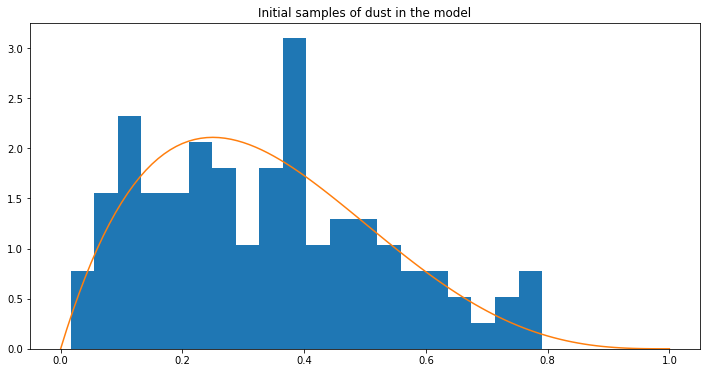

In [14]:
# Plotting the prior distribution of dust that was initialized in the simulation

plt.figure(figsize=(12,6))
plt.hist(prior_dust,bins=20,density=True)
x = np.linspace(0,1,101)
plt.title('Initial samples of dust in the model')
plt.plot(x,dust_prior(x))
plt.show()

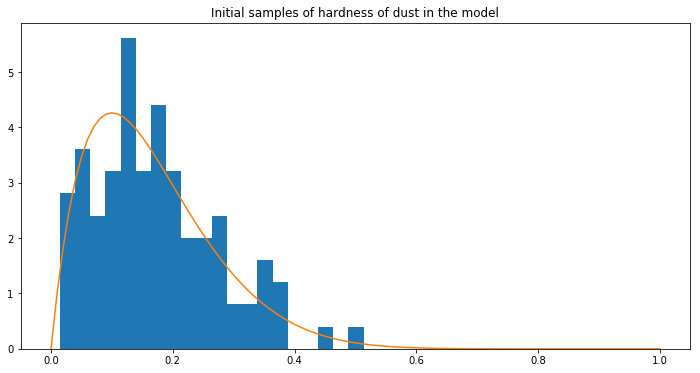

In [15]:
# Plotting the prior distribution of hardness that was initialized in the simulation

plt.figure(figsize=(12,6))
plt.hist(prior_hardness,bins=20,density=True)
x = np.linspace(0,1,101)
plt.title('Initial samples of hardness of dust in the model')
plt.plot(x,hardness_prior(x))
plt.show()

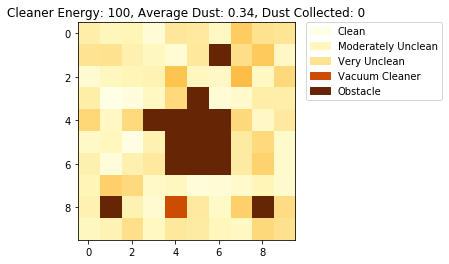

In [16]:
# Plotting the initial floor without any cleaning

sim = floor(10,10,0.001)
sim.initialize()
sim.observe()

In [17]:
# Selecting 5 random points in the initial simulation

points= []
i =0

while i < 5:
    
    x = random.choice(range(10))
    y = random.choice(range(10))
    
    if sim.floor[x,y].object == 0:
        points.append((x,y))
        i += 1

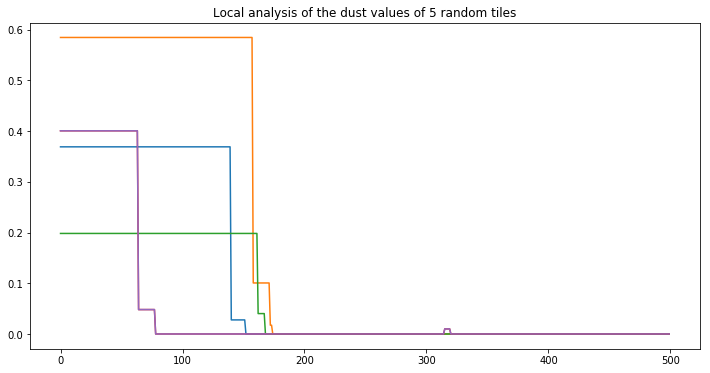

In [18]:
sim = floor(10,10,0.001)
sim.initialize()

dust_values = []

# Updating the simulation for 500 steps and collecting the variation in the dust values

for _ in range(500):
    sim.update('RB', intelligent= False)
    dust_array = []
    
    for point in points:
        dust_array.append(sim.floor[point].dust)
    
    # Collecting the values of dust for the five random points
    
    dust_values.append(dust_array)

dust_values = np.array(dust_values)

# Plotting the variation of dust in the 5 random tiles

plt.figure(figsize=(12,6))
plt.title('Local analysis of the dust values of 5 random tiles')
for i in range(5):
    plt.plot(range(500),dust_values[:,i])
plt.show()

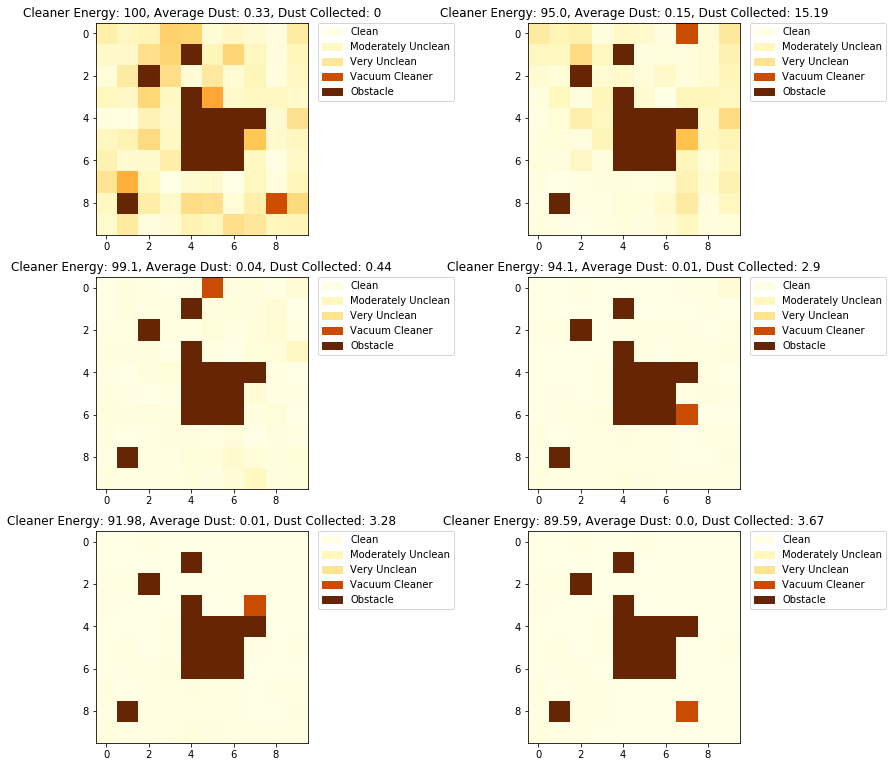

In [19]:
fig = plt.figure(figsize=(10,10)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.5)

sim = floor(10,10,0.001)
sim.initialize()
i = 0
for _ in range(6):
    
    fig.add_subplot(3, 2, i+1)
    
    if i !=0:
        for _ in range(50):
            sim.update('DTR',intelligent=True)
    
    sim.observe()
    
    i+= 1
    
plt.show()

In [20]:
# Animation GIF function

def roomba_gif_animation(strategy, frames=100, intelligent = False):
    sim = floor(10,10,0.001)
    sim.initialize()
    
    # The animate function with the update function
    
    def animate(frame,total_frames):
        sim.update(strategy,intelligent)
        plt.figure(figsize=(10,10))
        sim.observe()
        plt.show()
        
    # Making the dynamic animation using the code earlier

    animation = make_animation(
        animate, frames=frames, interval=100000 // frames,
        verbose=True, figure_params={'figsize': (4, 4)})

    return animation

In [ ]:
# Example simulation of a non-intelligent Random Bounce
# Commented out because the example recording has been added to the assignment

# You may remove the comment on the line below to run the animation
# roomba_gif_animation('DT', frames=10000, intelligent = False)

# Vector Fields

In [22]:
"""  This section plots the vector field for the variation of dust with different values of hardness: 
        1. It creates the x_grid and y_grid over the ranges of dust and hardness
        2. We know the formula for the change in dust, which we discussed earlier. 
                ( We plot the vector fields for six different values of performance)
        3. For each value of performance, we create the vectors and then perform the quiver plot
        """

def vector_field(performance):
    
    # Support of dust and hardness
    hardness = np.linspace(0,1,21)
    dust = np.linspace(0,1,11)
    
    # Creating the meshgrid
    x_grid, y_grid = np.meshgrid(hardness, dust)
    
    # Formula for the change in dust
    def dust_change(hardness,dust):
        return - dust*(1-hardness)*performance
    
    # Creating the vectors
    vector_x = x_grid # Dust
    vector_y = dust_change(x_grid, y_grid) # Change in dust
    
    plt.quiver(x_grid, y_grid, vector_x, vector_y) # Quiver plot
    plt.title('Vector field for change in dust with hardness, Performance: {}'.format(performance) )
    plt.xlabel('Hardness')
    plt.axvline(0.39, color='red')
    plt.axvline(0.44, color='red')
    plt.axhline(0.425)
    plt.axhline(0.525)
    plt.ylabel('Dust')

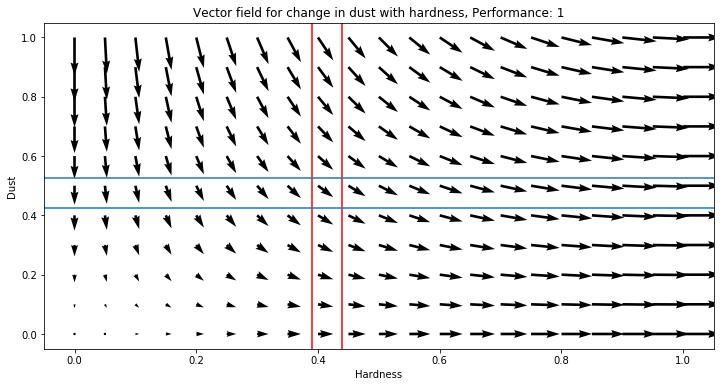

In [23]:
# The vector fields for the simulation with performance 1

plt.figure(figsize=(12, 6))
vector_field(1)
plt.show()

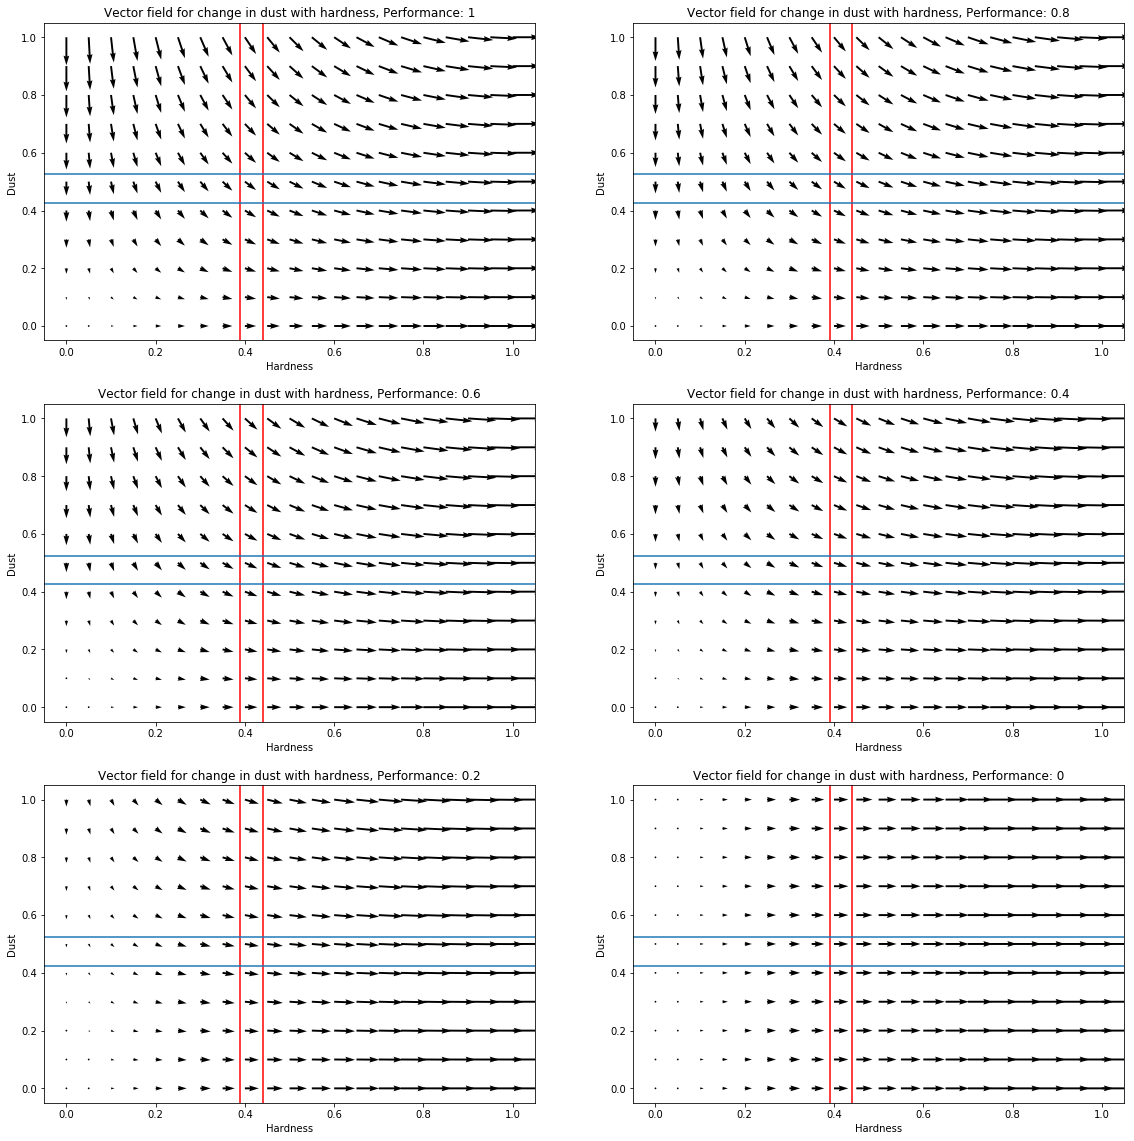

In [24]:
fig = plt.figure(figsize=(15,15)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)

i = 0

# The vector fields for the simulation with different values of performance

for performance in [1,0.8,0.6,0.4,0.2,0]:
    fig.add_subplot(3, 2, i+1)
    vector_field(performance)
    i+= 1
    
plt.show()

# Monte Carlo Simulations for Final Metrics

In [44]:
"""  This formula runs 500 monte carlo simulations for a given strategy. 
     It updates the simulation for 15000 steps and returns the final metrics:
         1. Average number of visits
         2. Average Cleaning times
         3. Total energy used  """

def simulation_for_final_metrics(strategy, intelligent):
    
    visits = []
    average_dust = []
    average_cleaning_times = []
    energy_used = []
    
    for _ in range(500):
        sim = floor(10,10,0.001)
        sim.initialize()
    
        for __ in range(10000): # Run 10000 steps
            sim.update(strategy,intelligent=intelligent)
    
        # Collect final metrics
        visits.append(sim.average_visits)
        average_cleaning_times.append(np.mean(sim.cleaning_times))
        energy_used.append(sim.cleaner.total_energy_used)
        average_dust.append(sim.average_dust)
    
    visits = np.array(visits)
    average_dust = np.array(average_dust)
    
    final_number_of_visits = visits[:,10000]    
    visit_means = [np.mean(visits[:,i]) for i in range(10001)] # Returning the mean path for the visits
    average_dust = [np.mean(average_dust[:,i]) for i in range(10001)] # Mean path for the dust
    
    return visit_means, average_cleaning_times, energy_used, final_number_of_visits, average_dust

In [45]:
# Running the Monte Carlo simulation for all the 6 strategies

all_visits = []
all_cleaning_times = []
all_energy_used = []

visit_paths = []
dust_paths = []

for strategy in ['RB','DT','DTR']:
    for intelligent in [False, True]:
        visit_means, average_cleaning_times, energy_used, final_number_of_visits, average_dust = \
                    simulation_for_final_metrics(strategy, intelligent)
        
        all_visits.append(final_number_of_visits)
        all_cleaning_times.append(average_cleaning_times)
        all_energy_used.append(energy_used)
        
        visit_paths.append(visit_means)
        dust_paths.append(average_dust)

In [29]:
strategies = ['Random Bounce', 'Intelligent Random Bounce', 'Dust Tracer', 'Intelligent Dust Tracer', \
             'Robust Dust Tracer', 'Intelligent Robust Dust Trace']

Analysis of Number of visits to each cell

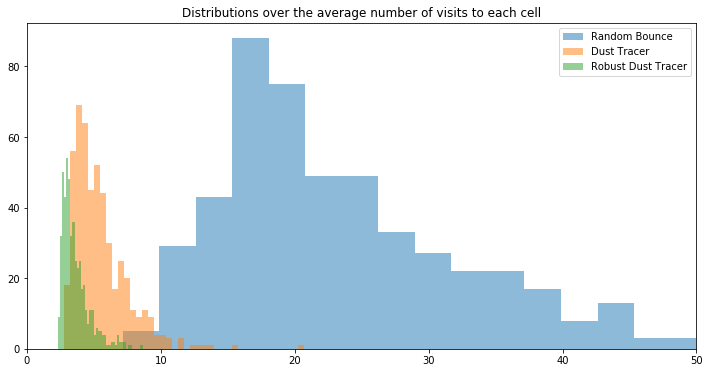

In [46]:
# For each non-intelligent strategy, we plot the histogram of the average number of visits
# This is because intelligence has no significant effect on the number of visits
# And hence, interpreting the visualization with 3 histograms becomes easier

plt.figure(figsize=(12,6))
plt.title('Distributions over the average number of visits to each cell')

i = 0

for strategy in strategies:
    if i%2 == 0:
        plt.hist(all_visits[i], alpha = 0.5, label= strategy, bins=40)
    i += 1

plt.xlim(0,50)
plt.legend()
plt.show()

In [47]:
# We calculate the means and confidence intervals for the average number of visits
# We then plot the data in a table

visit_means = [round(np.mean(all_visits[i]),2) for i in range(6)]
visit_bounds = [(round(np.percentile(all_visits[i],2.5),2),round(np.percentile(all_visits[i],97.5),2)) 
                for i in range(6)]

table = go.Table(
    header=dict(values=['Strategy', 'Mean','95% Confidence Intervals']),
    cells=dict(values=[strategies, visit_means, visit_bounds]))

final = [table]
layout = dict(width=800, height=600)
figure = dict(data=final, layout=layout)

py.iplot(figure, filename = 'Final Table - visits')

/usr/local/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



Analysis of cleaning time

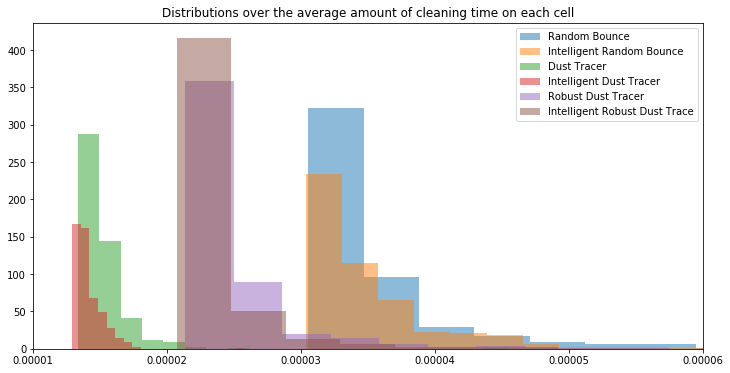

In [50]:
# We plot the histograms of average cleaning time for all 6 strategies

plt.figure(figsize=(12,6))
plt.title('Distributions over the average amount of cleaning time on each cell')

i = 0
for strategy in strategies:
    plt.hist(all_cleaning_times[i],alpha = 0.5, label= strategy,bins=20)
    i += 1

plt.xlim(0.00001,0.00006)
plt.legend()
plt.show()

In [51]:
# We calculate the means and confidence intervals for the average cleaning time
# We then plot the data in a table

time_means = [round(np.mean(all_cleaning_times[i])*10**5,1) for i in range(6)]
time_bounds = [(round(np.percentile(all_cleaning_times[i],2.5)*10**5,1),
                round(np.percentile(all_cleaning_times[i],97.5)*10**5,1)) 
                for i in range(6)]

table = go.Table(
    header=dict(values=['Strategy', 'Mean (x 10^(-5)) ','Confidence Intervals(x 10^(-5))']),
    cells=dict(values=[strategies, time_means, time_bounds]))

final = [table]
layout = dict(width=900, height=600)
figure = dict(data=final, layout=layout)

py.iplot(figure, filename = 'Final Table - cleaning times')

Analysis of average amount of energy used

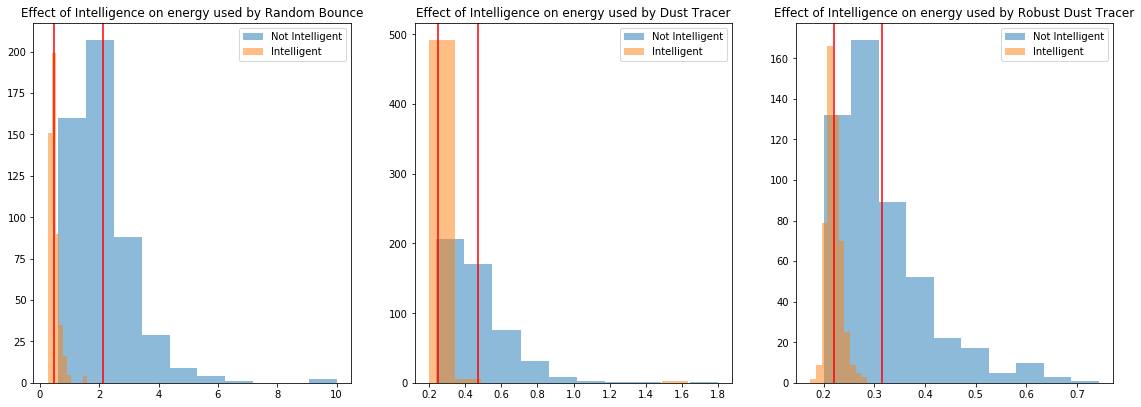

In [52]:
# We use a cross sectional visualization approach to plot the histograms of average energy used
# This allows us to see the effect of intelligence

fig = plt.figure(figsize=(15,5)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)

i = 0

for strategy in ['Random Bounce', 'Dust Tracer', 'Robust Dust Tracer']:
    fig.add_subplot(1, 3, i+1)
    
    plt.title('Effect of Intelligence on energy used by ' + strategy)
    plt.hist(all_energy_used[2*i],label= 'Not Intelligent',alpha = 0.5)
    plt.hist(all_energy_used[2*i +1],label= 'Intelligent',alpha=0.5)
    
    plt.axvline(np.mean(all_energy_used[2*i]), color='red')
    plt.axvline(np.mean(all_energy_used[2*i+1]), color='red')
    plt.legend()
    i+= 1
    
plt.show()

In [53]:
# We calculate the means and confidence intervals for the average energy used
# We then plot the data in a table

energy_means = [round(np.mean(all_energy_used[i]),2) for i in range(6)]
energy_bounds = [(round(np.percentile(all_energy_used[i],2.5),2),
                round(np.percentile(all_energy_used[i],97.5),2)) 
                for i in range(6)]

table = go.Table(
    header=dict(values=['Strategy', 'Mean','Confidence Intervals']),
    cells=dict(values=[strategies, energy_means, energy_bounds]))

final = [table]
layout = dict(width=900, height=600)
figure = dict(data=final, layout=layout)

py.iplot(figure, filename = 'Final Table - energy')

# Monte Carlo Simulations for path metrics

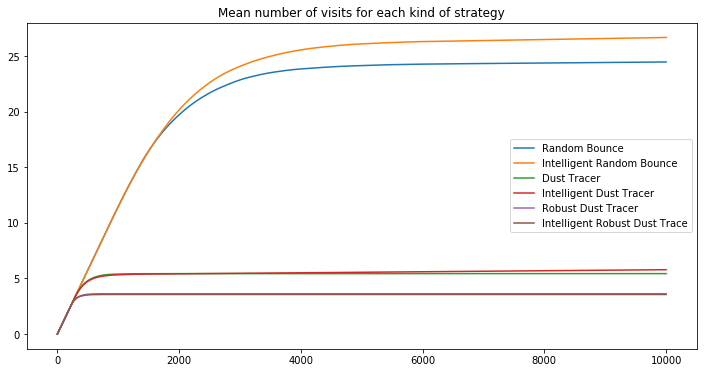

In [54]:
# Plotting the mean path for the number of visits for each strategy

plt.figure(figsize=(12,6))
plt.title('Mean number of visits for each kind of strategy')

i = 0
for strategy in strategies:
    plt.plot(range(10001),visit_paths[i], label = strategy)
    i += 1

plt.legend()
plt.show()

In [55]:
# Collecting the final number of visits that the strategy converged to (the final number)

final_number_visits = []
i =0
for strategy in strategies:
    final_number_visits.append(round(visit_paths[i][-1],2)) # The final number
    i += 1

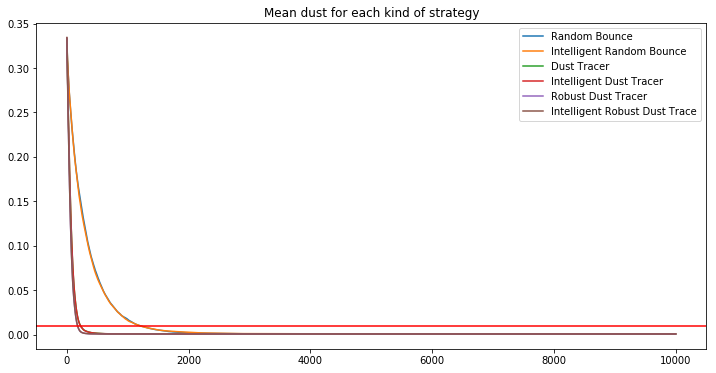

In [56]:
# We plot the mean path for the average amount of dust for all 6 strategies

plt.figure(figsize=(12,6))
plt.title('Mean dust for each kind of strategy')

i = 0
for strategy in strategies:
    plt.plot(range(10001),dust_paths[i], label= strategy)
    i += 1

plt.axhline(0.01,color='red')
plt.legend()
plt.show()

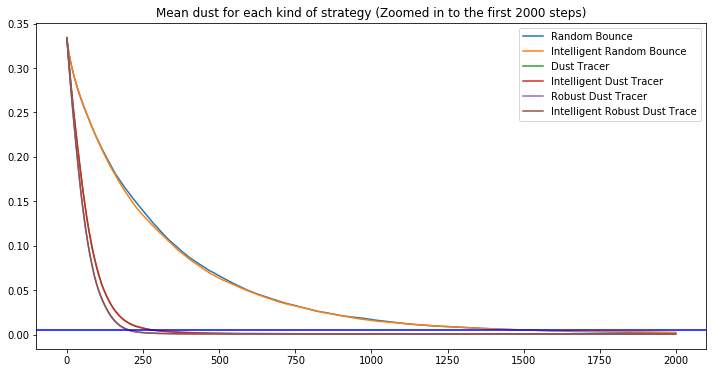

In [57]:
# A version of the above plot, but only for the first 10000 steps

plt.figure(figsize=(12,6))
plt.title('Mean dust for each kind of strategy (Zoomed in to the first 2000 steps)')

i = 0
for strategy in strategies:
    plt.plot(range(2000),dust_paths[i][0:2000],label=strategy)
    i += 1

plt.axhline(0.005,color='blue')
plt.legend()
plt.show()

In [58]:
j = 0

# For each strategy, we collect the number of steps that it took for each strategy to converge

dust_convergence_points = []

for strategy in strategies:
    paths = dust_paths[j]
    
    convergence_point = 0
    
    for i in range(0,len(paths)):
        if paths[i] < 0.005:
            convergence_point = i
            dust_convergence_points.append(convergence_point)
            break
            
        if i == len(paths) - 1:
            convergence_point = i
            dust_convergence_points.append(convergence_point)

    j += 1

In [59]:
# We visualize the number of steps taken to converge in a table

table = go.Table(
header=dict(values=['Strategy','Average number of visits','Steps taken to converge']),
cells=dict(values=[strategies,final_number_visits, dust_convergence_points]))

final = [table]
layout = dict(width=900, height=600)
figure = dict(data=final, layout=layout)

py.iplot(figure, filename = 'Final Table - steps')

# Utility function

In [102]:
i = 0
total_time_taken = []

for strategy in strategies:
    # We evaluate the score and record it
    total_time_taken.append(round(time_means[i]*dust_convergence_points[i],2))
    
    i += 1

In [103]:
scaler1 = MinMaxScaler((0,1))
total_time_taken = scaler1.fit_transform(np.array(total_time_taken).reshape(-1,1)).reshape(6)

scaler2 = MinMaxScaler((0,1))
energy_taken = scaler2.fit_transform(np.array(energy_means).reshape(-1,1)).reshape(6)

In [106]:
# We evaluate the scores of each strategy using the utlity function discussed in the assignment

i = 0
scores = []
time_scores = []
energy_scores = []

for strategy in strategies:
    # We evaluate the score and record it
    score = round(100*(1 - 0.5*total_time_taken[i] - 0.5*energy_taken[i]),4)
    score2 = round(100*(1 - 0.75*total_time_taken[i] - 0.25*energy_taken[i]),4)
    score3 = round(100*(1 - 0.25*total_time_taken[i] - 0.75*energy_taken[i]),4)
    
    scores.append(score)
    time_scores.append(score2)
    energy_scores.append(score3)
    i += 1

In [105]:
# We present the final utility for each strategy in a table

table = go.Table(
    header=dict(values=['Strategy', 'Strategy Score']),
    cells=dict(values=[strategies, scores]))

final = [table]
layout = dict(width=900, height=600)
figure = dict(data=final, layout=layout)

py.iplot(figure, filename = 'Final Table - utility')

/usr/local/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [108]:
table = go.Table(
    header=dict(values=['Strategy', 'Utility (0.75*Time + 0.25*Energy)','Utility (0.25*Time + 0.75*Energy)']),
    cells=dict(values=[strategies, time_scores,energy_scores]))

final = [table]
layout = dict(width=900, height=600)
figure = dict(data=final, layout=layout)

py.iplot(figure, filename = 'Final Table - final utility')